In [1]:
import numpy as np
import pandas as pd
import cv2
import os
import pickle
import matplotlib.pyplot as plt
from tqdm import tqdm
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, Input, BatchNormalization, Activation, GlobalAveragePooling2D
from tensorflow.keras.metrics import AUC
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.applications import ResNet50, DenseNet121
import tensorflow as tf
import sklearn

In [2]:
csv_file_path = '../DL_for_Hin_Chest_X_Ray/Data_Entry_2017_filtered_2.csv'
# csv_file_path = '../DL_for_Hin_Chest_X_Ray/HIN_archive/Data_Entry_2017.csv'
df = pd.read_csv(csv_file_path)

IMAGE_DIR = "../DL_for_Hin_Chest_X_Ray/HIN_archive/images/"
ALL_LABELS = sorted(df["Finding Labels"].str.split("|").explode().unique())
ALL_LABELS_WITHOUT_NO = [l for l in ALL_LABELS if l != "No Finding"]
NUMBER_CLASSES = len(ALL_LABELS)

def preprocess_image(file_path, image_size):
    image = cv2.imread(file_path, cv2.IMREAD_GRAYSCALE)
    if image is None:
        return None
    image = cv2.resize(image, (image_size, image_size))
    return image

def prepare_data(df, image_size, image_dir=IMAGE_DIR):
    images = []
    labels = []
    
    for _, row in tqdm(df.iterrows(), total=len(df)):
        image_path = os.path.join(image_dir, row["Image Index"])
        image = preprocess_image(image_path, image_size)
        
        if image is not None:
            images.append(image)

            current_label = np.zeros(NUMBER_CLASSES, dtype=int)
        
            if row["Finding Labels"] != "No Finding":
                indices = [i for i, label in enumerate(ALL_LABELS_WITHOUT_NO) if label in sorted(row["Finding Labels"].split("|"))]
                for idx in indices:
                    if 0 <= idx < NUMBER_CLASSES:
                        current_label[idx] = 1
            else:
                current_label[NUMBER_CLASSES - 1] = 1
            labels.append(current_label)
    
    images = np.array(images).reshape(-1, image_size, image_size)
    images = np.repeat(images[..., np.newaxis], 3, axis=-1) #rgb
    
    labels = np.array(labels)
    
    return images, labels

In [7]:
def create_resnet_model(image_size):
    base_model = tf.keras.applications.ResNet50(include_top=False, weights='imagenet', input_shape=(image_size, image_size, 3), pooling=None)
    base_model.trainable = False
    
    model = Sequential()
    model.add(base_model)
    model.add(Conv2D(2048, (1, 1), activation='relu')) # Transition Layer
    model.add(GlobalAveragePooling2D())   
    model.add(Dense(NUMBER_CLASSES, activation='softmax'))
    model.compile(optimizer=Adam(learning_rate=1e-4), loss='categorical_crossentropy', metrics=[AUC(multi_label=True)])
    return model

In [7]:
def normalize_image(img, label):
    img = tf.cast(img, np.float32)# / 255.0
    img = tf.keras.applications.resnet.preprocess_input(img)
    return img, label

def create_train_dataset(images_train, labels_train, batch_size=16):
    train_dataset = tf.data.Dataset.from_tensor_slices((images_train, labels_train))
    train_dataset = train_dataset.map(normalize_image)
    train_dataset = train_dataset.shuffle(buffer_size=100)
    train_dataset = train_dataset.batch(batch_size, drop_remainder=True)
    train_dataset = train_dataset.repeat()
    return train_dataset

def create_val_dataset(images_val, labels_val, batch_size=16):
    val_dataset = tf.data.Dataset.from_tensor_slices((images_val, labels_val))
    val_dataset = val_dataset.map(normalize_image)
    val_dataset = val_dataset.batch(batch_size, drop_remainder=False)
    return val_dataset

In [5]:
def evaluate_model(model, images_test, labels_test, batch_size=16):

    # images_test_2 = tf.cast(images_test, np.float32)
    images_test_2 = []
    
    for sample in images_test:
        images_test_2.append(normalize_image(sample, None)) 
    
    images_test_2 = np.array([tensor[0].numpy() for tensor in images_test_2])
    
    predictions = model.predict(images_test_2, batch_size=batch_size)
    
    auc_per_class = []
    
    for class_idx in range(NUMBER_CLASSES):
        true_labels_class = labels_test[:, class_idx]
        
        auc = sklearn.metrics.roc_auc_score(true_labels_class, predictions[:, class_idx])
        auc_per_class.append(auc)
        
    predicted_classes = np.argmax(predictions, axis=1)
    true_classes = np.argmax(labels_test, axis=1)
    balanced_accuracy = sklearn.metrics.balanced_accuracy_score(true_classes, predicted_classes)
    accuracy = sklearn.metrics.accuracy_score(true_classes, predicted_classes)
    
    return auc_per_class, balanced_accuracy, accuracy

In [1]:
NUMBER_OF_IMAGES = 10000
IMAGE_SIZE = 224
BATCH_SIZE = 16
EPOCHS_TO_TEST = 20
MODEL_PATH = 'models/resnet_12/'
images_test_list = {}
labels_test_list = {}

for run in range(0, 5):     

    df = df.sample(frac=1, random_state=42).reset_index(drop=True)

    images, labels = prepare_data(df[:NUMBER_OF_IMAGES], IMAGE_SIZE)
    images_train, images_val, labels_train, labels_val = sklearn.model_selection.train_test_split(images, labels, random_state=42, test_size=0.2)
    images_test, labels_test = prepare_data(df[-(int(NUMBER_OF_IMAGES / 5)):], IMAGE_SIZE)
    images_test_list[run] = images_test
    labels_test_list[run] = labels_test
    
    with open(f"{MODEL_PATH}{run}/images_test.pkl", "wb") as file:
        pickle.dump(images_test, file)
    with open(f"{MODEL_PATH}{run}/labels_test.pkl", "wb") as file:
        pickle.dump(labels_test, file)
    
    train_dataset = create_train_dataset(images_train, labels_train)
    val_dataset = create_val_dataset(images_val, labels_val)
        
    steps_per_epoch = len(images_train) // BATCH_SIZE
    validation_steps = len(images_val) // BATCH_SIZE
    
    checkpoint_callback = ModelCheckpoint(
        MODEL_PATH + str(run) +'/epoch_{epoch}.keras',
        save_freq=steps_per_epoch,
        save_best_only=False
    )
    
    reduceLR_callback = ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.1,
        patience=2,
        min_lr=1e-7
    )
    
    model = create_resnet_model(IMAGE_SIZE)
    
    history = model.fit(
        train_dataset,
        steps_per_epoch=steps_per_epoch,
        epochs=EPOCHS_TO_TEST,
        validation_data=val_dataset,
        validation_steps=validation_steps,
        callbacks=[checkpoint_callback, reduceLR_callback]
    )
    
    with open(f"{MODEL_PATH}{run}/history.pkl", "wb") as file:
        pickle.dump(history, file)
    with open(f"{MODEL_PATH}images_test_list.pkl", "wb") as file:
        pickle.dump(images_test_list, file)
    with open(f"{MODEL_PATH}labels_test_list.pkl", "wb") as file:
        pickle.dump(labels_test_list, file)

NameError: name 'df' is not defined

In [8]:
evaluations = {} 
MODEL_PATH = 'models/resnet_12/'
NUMBER_OF_IMAGES = 10000
IMAGE_SIZE = 224
BATCH_SIZE = 16
EPOCHS_TO_TEST = 20


for run in tqdm(range(0, 5)):

    with open(f'{MODEL_PATH}{run}/images_test.pkl', 'rb') as file:
        images_test = pickle.load(file)
    with open(f'{MODEL_PATH}{run}/labels_test.pkl', 'rb') as file:
        labels_test = pickle.load(file)    
    
    for epoch in range(1, EPOCHS_TO_TEST + 1, 1):
        model_path = f'{MODEL_PATH}{run}/epoch_{epoch}.keras'
        
        if os.path.exists(model_path):
            model = tf.keras.models.load_model(model_path)
            
            if not evaluations.get(epoch):
                evaluations[epoch] = []
            
            evaluations[epoch].append(evaluate_model(model, images_test, labels_test))
        else:
            print(f"Run {run}: Model for epoch {epoch} not found!")
    
    print(evaluations)

# with open(f"{MODEL_PATH}images_test_list.pkl", "wb") as file:
#     pickle.dump(images_test_list, file)
# with open(f"{MODEL_PATH}labels_test_list.pkl", "wb") as file:
#     pickle.dump(labels_test_list, file)
with open(f"{MODEL_PATH}evaluations.pkl", "wb") as file:
    pickle.dump(evaluations, file)

  0%|          | 0/5 [00:00<?, ?it/s]2025-03-28 15:39:36.940335: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


125/125 ━━━━━━━━━━━━━━━━━━━━ 14s 88ms/step
125/125 ━━━━━━━━━━━━━━━━━━━━ 14s 89ms/step
125/125 ━━━━━━━━━━━━━━━━━━━━ 14s 88ms/step
125/125 ━━━━━━━━━━━━━━━━━━━━ 13s 88ms/step
125/125 ━━━━━━━━━━━━━━━━━━━━ 19s 101ms/step
125/125 ━━━━━━━━━━━━━━━━━━━━ 14s 89ms/step
125/125 ━━━━━━━━━━━━━━━━━━━━ 16s 101ms/step
125/125 ━━━━━━━━━━━━━━━━━━━━ 22s 106ms/step
125/125 ━━━━━━━━━━━━━━━━━━━━ 15s 85ms/step
125/125 ━━━━━━━━━━━━━━━━━━━━ 15s 85ms/step
125/125 ━━━━━━━━━━━━━━━━━━━━ 14s 87ms/step
125/125 ━━━━━━━━━━━━━━━━━━━━ 15s 91ms/step
125/125 ━━━━━━━━━━━━━━━━━━━━ 14s 83ms/step
125/125 ━━━━━━━━━━━━━━━━━━━━ 14s 81ms/step
125/125 ━━━━━━━━━━━━━━━━━━━━ 13s 82ms/step
125/125 ━━━━━━━━━━━━━━━━━━━━ 14s 84ms/step
125/125 ━━━━━━━━━━━━━━━━━━━━ 14s 80ms/step
125/125 ━━━━━━━━━━━━━━━━━━━━ 20s 91ms/step
125/125 ━━━━━━━━━━━━━━━━━━━━ 14s 82ms/step
125/125 ━━━━━━━━━━━━━━━━━━━━ 14s 81ms/step


 20%|██        | 1/5 [09:55<39:43, 595.96s/it]

{1: [([0.7062212201328405, 0.7938669238187079, 0.6460210298052246, 0.6992193886132121], 0.34771403154822234, 0.672)], 2: [([0.7107191771676222, 0.7979395692703309, 0.6623082083323584, 0.7121323499143174], 0.33209327503164915, 0.6735)], 3: [([0.7175633967777995, 0.8022918675666988, 0.6660679880498288, 0.7160618702446746], 0.34493904505758133, 0.669)], 4: [([0.7203560215016843, 0.8038508518161364, 0.6762962269596486, 0.7154291010325429], 0.32682764826357513, 0.691)], 5: [([0.7221376550345453, 0.8034490517518481, 0.6775637875490448, 0.7153208951449666], 0.3194268968372723, 0.692)], 6: [([0.7230341943926233, 0.8052523304403729, 0.6781741667251695, 0.7136272377742048], 0.3349507430163871, 0.6895)], 7: [([0.7232554679363189, 0.8057891353262616, 0.6777509964976326, 0.714468185704826], 0.3603746461830166, 0.6895)], 8: [([0.7237285355124963, 0.8056509161041466, 0.6775676877354737, 0.7135131511318689], 0.346694496367458, 0.6845)], 9: [([0.7249035743307429, 0.8042430086788813, 0.6774116802783173,

 40%|████      | 2/5 [18:38<27:37, 552.66s/it]

125/125 ━━━━━━━━━━━━━━━━━━━━ 13s 82ms/step
125/125 ━━━━━━━━━━━━━━━━━━━━ 14s 84ms/step
125/125 ━━━━━━━━━━━━━━━━━━━━ 14s 83ms/step
125/125 ━━━━━━━━━━━━━━━━━━━━ 16s 81ms/step
125/125 ━━━━━━━━━━━━━━━━━━━━ 13s 79ms/step
125/125 ━━━━━━━━━━━━━━━━━━━━ 14s 82ms/step
125/125 ━━━━━━━━━━━━━━━━━━━━ 16s 78ms/step
125/125 ━━━━━━━━━━━━━━━━━━━━ 15s 79ms/step
125/125 ━━━━━━━━━━━━━━━━━━━━ 13s 79ms/step
125/125 ━━━━━━━━━━━━━━━━━━━━ 14s 79ms/step
125/125 ━━━━━━━━━━━━━━━━━━━━ 14s 80ms/step
125/125 ━━━━━━━━━━━━━━━━━━━━ 15s 89ms/step
125/125 ━━━━━━━━━━━━━━━━━━━━ 14s 82ms/step
125/125 ━━━━━━━━━━━━━━━━━━━━ 15s 83ms/step
125/125 ━━━━━━━━━━━━━━━━━━━━ 14s 83ms/step
125/125 ━━━━━━━━━━━━━━━━━━━━ 17s 86ms/step
125/125 ━━━━━━━━━━━━━━━━━━━━ 15s 86ms/step
125/125 ━━━━━━━━━━━━━━━━━━━━ 17s 85ms/step
125/125 ━━━━━━━━━━━━━━━━━━━━ 16s 83ms/step
125/125 ━━━━━━━━━━━━━━━━━━━━ 15s 83ms/step


 60%|██████    | 3/5 [27:59<18:33, 556.51s/it]

{1: [([0.7062212201328405, 0.7938669238187079, 0.6460210298052246, 0.6992193886132121], 0.34771403154822234, 0.672), ([0.7652509133101555, 0.8254511032449833, 0.6408742576213237, 0.733927875062673], 0.33794156063368874, 0.65), ([0.6828799623986093, 0.8268395392174543, 0.6663730772773325, 0.7262542637371742], 0.3064981675451375, 0.682)], 2: [([0.7107191771676222, 0.7979395692703309, 0.6623082083323584, 0.7121323499143174], 0.33209327503164915, 0.6735), ([0.754059973683215, 0.8282816758963479, 0.6396742672212469, 0.7298111919927206], 0.38453286822881555, 0.6305), ([0.6842519984378834, 0.8404883712836673, 0.6666781799760524, 0.714092543235791], 0.3082828000619561, 0.66)], 3: [([0.7175633967777995, 0.8022918675666988, 0.6660679880498288, 0.7160618702446746], 0.34493904505758133, 0.669), ([0.7618667260826246, 0.8377138346550895, 0.6437302347735064, 0.7365427290115318], 0.3778444993998142, 0.6895), ([0.687956841344941, 0.838099667479775, 0.6659797058733229, 0.7162664162512257], 0.31025309497

 80%|████████  | 4/5 [39:43<10:14, 614.77s/it]

{1: [([0.7062212201328405, 0.7938669238187079, 0.6460210298052246, 0.6992193886132121], 0.34771403154822234, 0.672), ([0.7652509133101555, 0.8254511032449833, 0.6408742576213237, 0.733927875062673], 0.33794156063368874, 0.65), ([0.6828799623986093, 0.8268395392174543, 0.6663730772773325, 0.7262542637371742], 0.3064981675451375, 0.682), ([0.705908215709759, 0.7905671779229374, 0.6339754682749549, 0.7216290250447227], 0.2902178689724823, 0.686)], 2: [([0.7107191771676222, 0.7979395692703309, 0.6623082083323584, 0.7121323499143174], 0.33209327503164915, 0.6735), ([0.754059973683215, 0.8282816758963479, 0.6396742672212469, 0.7298111919927206], 0.38453286822881555, 0.6305), ([0.6842519984378834, 0.8404883712836673, 0.6666781799760524, 0.714092543235791], 0.3082828000619561, 0.66), ([0.7211032611167544, 0.7995581262249847, 0.6460033620228488, 0.7239082532051282], 0.27839329174434124, 0.688)], 3: [([0.7175633967777995, 0.8022918675666988, 0.6660679880498288, 0.7160618702446746], 0.34493904505

100%|██████████| 5/5 [56:05<00:00, 673.01s/it]

{1: [([0.7062212201328405, 0.7938669238187079, 0.6460210298052246, 0.6992193886132121], 0.34771403154822234, 0.672), ([0.7652509133101555, 0.8254511032449833, 0.6408742576213237, 0.733927875062673], 0.33794156063368874, 0.65), ([0.6828799623986093, 0.8268395392174543, 0.6663730772773325, 0.7262542637371742], 0.3064981675451375, 0.682), ([0.705908215709759, 0.7905671779229374, 0.6339754682749549, 0.7216290250447227], 0.2902178689724823, 0.686), ([0.6878492815890658, 0.807412056963707, 0.6559021229266406, 0.7103521845518485], 0.29297222432541387, 0.6755)], 2: [([0.7107191771676222, 0.7979395692703309, 0.6623082083323584, 0.7121323499143174], 0.33209327503164915, 0.6735), ([0.754059973683215, 0.8282816758963479, 0.6396742672212469, 0.7298111919927206], 0.38453286822881555, 0.6305), ([0.6842519984378834, 0.8404883712836673, 0.6666781799760524, 0.714092543235791], 0.3082828000619561, 0.66), ([0.7211032611167544, 0.7995581262249847, 0.6460033620228488, 0.7239082532051282], 0.2783932917443412

In [6]:
# resnet 12
evaluations = {1: [([0.7062212201328405, 0.7938669238187079, 0.6460210298052246, 0.6992193886132121], 0.34771403154822234, 0.672), ([0.7652509133101555, 0.8254511032449833, 0.6408742576213237, 0.733927875062673], 0.33794156063368874, 0.65), ([0.6828799623986093, 0.8268395392174543, 0.6663730772773325, 0.7262542637371742], 0.3064981675451375, 0.682), ([0.705908215709759, 0.7905671779229374, 0.6339754682749549, 0.7216290250447227], 0.2902178689724823, 0.686), ([0.6878492815890658, 0.807412056963707, 0.6559021229266406, 0.7103521845518485], 0.29297222432541387, 0.6755)], 2: [([0.7107191771676222, 0.7979395692703309, 0.6623082083323584, 0.7121323499143174], 0.33209327503164915, 0.6735), ([0.754059973683215, 0.8282816758963479, 0.6396742672212469, 0.7298111919927206], 0.38453286822881555, 0.6305), ([0.6842519984378834, 0.8404883712836673, 0.6666781799760524, 0.714092543235791], 0.3082828000619561, 0.66), ([0.7211032611167544, 0.7995581262249847, 0.6460033620228488, 0.7239082532051282], 0.27839329174434124, 0.688), ([0.6971621600585314, 0.8125033211116424, 0.664548575849896, 0.7136612693971149], 0.334252101254861, 0.6865)], 3: [([0.7175633967777995, 0.8022918675666988, 0.6660679880498288, 0.7160618702446746], 0.34493904505758133, 0.669), ([0.7618667260826246, 0.8377138346550895, 0.6437302347735064, 0.7365427290115318], 0.3778444993998142, 0.6895), ([0.687956841344941, 0.838099667479775, 0.6659797058733229, 0.7162664162512257], 0.3102530949745479, 0.6725), ([0.723081762913325, 0.7891123836564256, 0.649881301175185, 0.7266364555381635], 0.27441377383466237, 0.6865), ([0.7036768940986006, 0.8166613528880388, 0.6607437496977611, 0.7130663910278623], 0.3706593951888329, 0.651)], 4: [([0.7203560215016843, 0.8038508518161364, 0.6762962269596486, 0.7154291010325429], 0.32682764826357513, 0.691), ([0.7634221910195021, 0.8383212669125175, 0.6440311554430642, 0.7307605708343392], 0.3403658343898246, 0.6845), ([0.6839547815628769, 0.83993469821654, 0.672901123698996, 0.7295018389883954], 0.34330141892516325, 0.6875), ([0.7322465470974393, 0.7937549359091186, 0.6518269338770443, 0.7300727675909363], 0.2994290507600218, 0.689), ([0.6955509892744284, 0.8154092937988203, 0.6616509502393733, 0.7093374616078747], 0.3401136585951572, 0.6665)], 5: [([0.7221376550345453, 0.8034490517518481, 0.6775637875490448, 0.7153208951449666], 0.3194268968372723, 0.692), ([0.7474555536404186, 0.8335974790019611, 0.646800364058626, 0.722939221184379], 0.38202807697965485, 0.5995), ([0.6817602151020733, 0.8410198974281096, 0.6725288600288599, 0.7286559963910716], 0.3378834777615575, 0.686), ([0.7492495338013008, 0.8017898765503152, 0.6565786943700396, 0.7338613875223612], 0.3244071881677245, 0.6875), ([0.700419527078566, 0.815801184972634, 0.6633686348469462, 0.7080341694350785], 0.3270485892537083, 0.6945)], 6: [([0.7230341943926233, 0.8052523304403729, 0.6781741667251695, 0.7136272377742048], 0.3349507430163871, 0.6895), ([0.7562712562691544, 0.8349140961284672, 0.6515283262349285, 0.7371833856381497], 0.3777614038932272, 0.6875), ([0.6815252064102076, 0.8411084851188498, 0.672191136286881, 0.7278067013749833], 0.3404475291297134, 0.687), ([0.7541540957261329, 0.8014125892460329, 0.6580502932727179, 0.7341071295468098], 0.3194803701879021, 0.6905), ([0.6997929606625258, 0.8165982517668313, 0.6625446104743944, 0.7064984844202182], 0.31716966542138725, 0.6915)], 7: [([0.7232554679363189, 0.8057891353262616, 0.6777509964976326, 0.714468185704826], 0.3603746461830166, 0.6895), ([0.7526474433621586, 0.8359316222449709, 0.6533763114510468, 0.73049595179291], 0.33633270433708723, 0.6865), ([0.6808236363447854, 0.8413267904996028, 0.6723791870068465, 0.7297895405521108], 0.34292449834750866, 0.6915), ([0.7552229415242803, 0.8012751031944725, 0.6585795358276268, 0.7335591597719142], 0.30879746569936956, 0.691), ([0.6995866996684257, 0.8163192783888624, 0.6624343536921515, 0.7055754176862188], 0.3187131507874185, 0.695)], 8: [([0.7237285355124963, 0.8056509161041466, 0.6775676877354737, 0.7135131511318689], 0.346694496367458, 0.6845), ([0.7508649646236826, 0.8347784259796003, 0.6534409263187433, 0.7266879909379584], 0.3284414312755334, 0.685), ([0.6803328829000072, 0.8411591066564157, 0.6720050044518129, 0.7295582284948835], 0.3434518170644584, 0.6895), ([0.7553859215573311, 0.8011216303927304, 0.6596913259429751, 0.7295335327221228], 0.31814756985046333, 0.687), ([0.702661155995579, 0.8155985971624422, 0.6635891484114318, 0.704647028978737], 0.3311251098050121, 0.6915)], 9: [([0.7249035743307429, 0.8042430086788813, 0.6774116802783173, 0.7110949847747259], 0.32532264216012907, 0.693), ([0.7486536820377432, 0.834642755830733, 0.6546169169108185, 0.7300317078605782], 0.34368187584313514, 0.688), ([0.6801220662793631, 0.8411717620408072, 0.6717536305302263, 0.729212986618425], 0.34319078954572163, 0.6905), ([0.7557194620900862, 0.80098414434117, 0.6596513471888272, 0.7292621683064997], 0.31848210223545603, 0.687), ([0.7024276529833902, 0.8157546894096392, 0.6638812321678998, 0.7049196322871121], 0.33194478193615967, 0.692)], 10: [([0.7243160549216195, 0.8041497910639667, 0.6772732236600909, 0.7105233754120939], 0.32633070186304686, 0.694), ([0.7482248781902796, 0.8343714155329987, 0.6547424543680573, 0.7294978273383967], 0.34427365390774445, 0.688), ([0.6800252979944774, 0.8410135697359136, 0.6717248472567621, 0.7290242543926275], 0.34245657515511957, 0.6885), ([0.7561136463560696, 0.8008690397398636, 0.6594076671635454, 0.7292808027728086], 0.3178599297610673, 0.687), ([0.7021046404831955, 0.8158310749774165, 0.6640495188355338, 0.704998279228574], 0.33394306374332194, 0.694)], 11: [([0.7240757060724328, 0.8042847958855673, 0.6771055156436477, 0.7102034623531722], 0.32839083067782915, 0.6935), ([0.7481029633709028, 0.8342234117342345, 0.6548070692357539, 0.7293898906241296], 0.34545721003696306, 0.688), ([0.6800909621877926, 0.841149615118122, 0.6716193085873937, 0.7289966350425108], 0.3422963636334709, 0.6915), ([0.7560795342561288, 0.8008434609395733, 0.6595295071761863, 0.7291293977340488], 0.31804161580757895, 0.6875), ([0.7021941499712012, 0.8158277538657739, 0.6641152860389767, 0.704930867564464], 0.3341225325157555, 0.6945)], 12: [([0.7239459939950939, 0.8043137254901962, 0.6771445175079369, 0.7100646765408459], 0.3257319376062358, 0.6915), ([0.7481365950452137, 0.8341401595974297, 0.6548661456862191, 0.72923669012646], 0.3462312038450126, 0.6885), ([0.6801116982488395, 0.8411939089634923, 0.6715559853857727, 0.7289977858487657], 0.3426634708287719, 0.6925), ([0.7560681635561485, 0.800808290089174, 0.6595675821801367, 0.7290734943351223], 0.3182233018540906, 0.688), ([0.7022330671398995, 0.8159008183219087, 0.6641152860389767, 0.70481023616553], 0.33394306374332194, 0.694)], 13: [([0.723892583139719, 0.804333011893282, 0.677098690317397, 0.7099576468042214], 0.3271444969848631, 0.691), ([0.7479600287550815, 0.8341093254726871, 0.654908606884991, 0.7291949081725502], 0.3462312038450126, 0.6885), ([0.6801082422386652, 0.8412223835783732, 0.6715214454576156, 0.7289954842362558], 0.3426634708287719, 0.6925), ([0.756079534256129, 0.8008434609395734, 0.659598042183297, 0.7289756633870006], 0.3182233018540906, 0.688), ([0.7021902582543315, 0.8159240661034062, 0.6641114173799506, 0.7048114188263037], 0.3343020012881891, 0.695)], 14: [([0.7237857614289692, 0.8042783670845387, 0.6770684638725731, 0.7098412078599816], 0.32732474211824447, 0.6915), ([0.7479978643886812, 0.8341185757101098, 0.654908606884991, 0.7291589292677945], 0.34500892520643034, 0.6885), ([0.6801220662793631, 0.8412192197322753, 0.6715272021123084, 0.7289126261859059], 0.34247991723112137, 0.692), ([0.7560681635561486, 0.8008658423898273, 0.6595618709295441, 0.7289407237626714], 0.3199838652343723, 0.6885), ([0.7021630162362427, 0.8159141027684786, 0.6641133517094637, 0.704784217628505], 0.3341225325157555, 0.6945)], 15: [([0.7237094602070051, 0.8042783670845388, 0.6770470128472141, 0.7097671103500107], 0.3271444969848631, 0.691), ([0.7479348049993484, 0.8340692411105218, 0.6549455296665321, 0.7291206291433772], 0.34464449371954986, 0.6875), ([0.6800771381470947, 0.8412128920400795, 0.6715252832274109, 0.7288999673171024], 0.34247991723112137, 0.692), ([0.7560984854227627, 0.8008786317899724, 0.6595999459334944, 0.7289314065295169], 0.3199838652343723, 0.6885), ([0.7021202073506748, 0.8159074605451937, 0.6641191546980028, 0.70476588638651], 0.3341225325157555, 0.6945)], 16: [([0.7236751246571214, 0.80424943747991, 0.6770782143386453, 0.709776519557626], 0.32732474211824447, 0.6915), ([0.7478507258135711, 0.8340661576980476, 0.6549196837194534, 0.729080007799298], 0.3448267094629901, 0.688), ([0.6800909621877927, 0.8411749258869051, 0.6715156888029229, 0.7288896100608085], 0.34247991723112137, 0.692), ([0.7560416319228611, 0.8008690397398637, 0.659558063429149, 0.7289244186046513], 0.3199838652343723, 0.6885), ([0.7021046404831955, 0.8159340294383335, 0.6640978770733594, 0.7047511031268368], 0.3343020012881891, 0.695)], 17: [([0.7236674945349251, 0.8042815814850531, 0.6771055156436477, 0.7096847797833765], 0.32732474211824447, 0.6915), ([0.7478759495693045, 0.8340353235733051, 0.6549215298585304, 0.7290556349928506], 0.3448267094629901, 0.688), ([0.6800598580962223, 0.8411907451173946, 0.6714964999539468, 0.7288401253918495], 0.3426634708287719, 0.6925), ([0.7560757440228021, 0.8008594476897546, 0.6595637746797416, 0.7289168483527131], 0.3199838652343723, 0.6885), ([0.7021046404831957, 0.8159240661034062, 0.6641056143914116, 0.7047274499113596], 0.3343020012881891, 0.695)], 18: [([0.7236178987406482, 0.8042783670845387, 0.6770528631268575, 0.7096741944248093], 0.3271444969848631, 0.691), ([0.7478633376914378, 0.8339829055612427, 0.6548809147988355, 0.7289755529145234], 0.3448267094629901, 0.688), ([0.6800183859741283, 0.8411970728095903, 0.6715310398821038, 0.7287923669322728], 0.3426634708287719, 0.6925), ([0.7560719537894752, 0.8008498556396457, 0.6595104696742112, 0.7288807440742398], 0.3199838652343723, 0.6885), ([0.7021046404831957, 0.8159107816568362, 0.6641191546980028, 0.7047215366074903], 0.3343020012881891, 0.695)], 19: [([0.7235644878852735, 0.8042590806814529, 0.6770821145250743, 0.7096706659719534], 0.3271444969848631, 0.691), ([0.7478212980985491, 0.8339829055612428, 0.6548735302425273, 0.7289546619375685], 0.3462312038450126, 0.6885), ([0.6799769138520344, 0.8412445305010583, 0.6715348776518989, 0.7287653229852835], 0.3426634708287719, 0.6925), ([0.7560757440228021, 0.8008114874392104, 0.6594876246718411, 0.7288906436344664], 0.3199838652343723, 0.6885), ([0.702096857049456, 0.8158875338753389, 0.6640804681077421, 0.7046943354096914], 0.3343020012881891, 0.695)], 20: [([0.7234958167855058, 0.8042462230793958, 0.6770528631268575, 0.7096000969148384], 0.3271444969848631, 0.691), ([0.7477540347499274, 0.8339150704868091, 0.654906760745914, 0.7288734192494104], 0.3448267094629901, 0.688), ([0.6799872818825579, 0.8412128920400795, 0.6714984188388444, 0.728744608472696], 0.3428470244264224, 0.693), ([0.7561098561227431, 0.8007763165888111, 0.659480009671051, 0.7288696798598688], 0.3199838652343723, 0.6885), ([0.7021124239169352, 0.8158842127636963, 0.6641036800618986, 0.7046754128373096], 0.3344814700606227, 0.6955)]}

In [8]:
#resnet 11

evaluations = {1: [([0.6968894265532009, 0.8083831521739131, 0.6356848128472945, 0.6820683760683761], 0.3471386927000699, 0.6715), ([0.6677823587652023, 0.8225173483939687, 0.6749142770880807, 0.7197539381794522], 0.3037449456695714, 0.6885), ([0.7156900914930894, 0.7824475777295733, 0.6534411764705882, 0.6950771810140486], 0.3465846688722043, 0.6815), ([0.7093707593642533, 0.7966259093019656, 0.6414640324214792, 0.6963979700810478], 0.2956748025843503, 0.6995), ([0.7107526881720431, 0.8061414699497057, 0.6807232804715032, 0.7187292728160761], 0.36661231069125805, 0.6395)], 2: [([0.7055766449746927, 0.8097180706521739, 0.655437025109445, 0.6841150997150998], 0.3355911307726428, 0.6665), ([0.6708338874850379, 0.8269088541390207, 0.680300263818102, 0.721503598128303], 0.3096983313594357, 0.6845), ([0.7268266173512425, 0.7902657266811279, 0.6563941176470589, 0.6943003121928657], 0.3379755442857426, 0.6725), ([0.7207398457105678, 0.8059123974616933, 0.6483010193116576, 0.705968652393528], 0.3225674667560823, 0.6815), ([0.7176075268817205, 0.8117847927637573, 0.6824777463847368, 0.7162895120595054], 0.3320862514296467, 0.6975)], 3: [([0.7103078591690305, 0.814290081521739, 0.6508489623394268, 0.6820797720797722], 0.4165327997850453, 0.591), ([0.6716835867653795, 0.827503352902251, 0.6793981065480085, 0.7231030230749407], 0.29290060454560274, 0.6885), ([0.7338873207449226, 0.7917987652260972, 0.6619764705882353, 0.7059834557052282], 0.33865703229725896, 0.689), ([0.7268556557300864, 0.7964289231894865, 0.6486157164348655, 0.699400745785884], 0.3455835773133469, 0.67), ([0.7218509984639015, 0.8156375995574868, 0.6804346670312311, 0.7306646337269822], 0.37368428403000126, 0.675)], 4: [([0.7015406863563046, 0.8114232336956522, 0.6564685754541337, 0.6848957264957265], 0.32439366459388913, 0.6775), ([0.67032776226153, 0.8279315335591013, 0.67621359921214, 0.720253180648345], 0.3207243164533785, 0.6905), ([0.7297547206540782, 0.7904986372990711, 0.6531872549019607, 0.6963984602339519], 0.3007707330441042, 0.6935), ([0.7242531833813551, 0.803777208706786, 0.6432255687574836, 0.7035282318866631], 0.31946060351016164, 0.697), ([0.7189976958525346, 0.8138694649874183, 0.6878531717098069, 0.7271955806875392], 0.31029777183027957, 0.696)], 5: [([0.704672812725958, 0.8016949728260869, 0.6512874610922214, 0.6765019943019943], 0.3582391200504973, 0.6645), ([0.6674646451212483, 0.8247361027067388, 0.6730830056573528, 0.7192240708831854], 0.30124793515798415, 0.689), ([0.7251395107390826, 0.7904743033539129, 0.6584058823529412, 0.6903352700853713], 0.337891185773622, 0.6455), ([0.7153043963193605, 0.7938153395899875, 0.6477675693101226, 0.7008849850570811], 0.34196354027189235, 0.6865), ([0.7207795698924732, 0.8130925089286001, 0.6843195558391055, 0.7287878946834665], 0.3807294048973615, 0.6785)], 6: [([0.7011548195116524, 0.8099558423913044, 0.6489745598838338, 0.6796091168091167], 0.3588306453332651, 0.6585), ([0.671639254629014, 0.8243149994161173, 0.6700746166730166, 0.7126905817677113], 0.32226298744384374, 0.6925), ([0.7227913503341769, 0.7837928972690361, 0.6512705882352942, 0.6920443814919736], 0.2767986192277977, 0.6985), ([0.7020912724230877, 0.7835087447763505, 0.6501431488133615, 0.674004288327966], 0.33948782762896434, 0.636), ([0.7169623655913978, 0.8119510549656443, 0.6888196469801919, 0.72699566718073], 0.3367919573737427, 0.695)], 7: [([0.6924380527281829, 0.8035495923913043, 0.6476339038609455, 0.6742666666666666], 0.3680608601173721, 0.646), ([0.6661716244772502, 0.8198881068399206, 0.672588795997441, 0.7138970844008686], 0.3488417547988199, 0.683), ([0.7158807020959055, 0.7839006618833082, 0.6505980392156863, 0.6909483340078241], 0.33555815289526336, 0.667), ([0.7079505530253741, 0.7734976291314319, 0.6458793865708758, 0.6881477285225848], 0.3697115503626507, 0.6275), ([0.7157642089093703, 0.8132555737804508, 0.6729307175841536, 0.7162172401211837], 0.3598728260234968, 0.685)], 8: [([0.6906564603148116, 0.7900373641304349, 0.6459122571184163, 0.6636096866096866], 0.35905138441066586, 0.628), ([0.6654290611931256, 0.8186283356511708, 0.6767904766697099, 0.7177194095533282], 0.3540641230630317, 0.674), ([0.7177421971319187, 0.7752203960175761, 0.6409745098039216, 0.6754952689291013], 0.30011750761042544, 0.668), ([0.6942503950181245, 0.7812645101377496, 0.6457431457431457, 0.6777001032462856], 0.3645086156262729, 0.652), ([0.7097772657450077, 0.8062150090005402, 0.6769276339773971, 0.7067880835230472], 0.3472320297139698, 0.676)], 9: [([0.6835787585516435, 0.7819123641304346, 0.6452221607205757, 0.6598370370370371], 0.3123501128085709, 0.6575), ([0.6624514193672326, 0.8175808854492889, 0.6644460179281294, 0.7027843168525536], 0.3369864405202231, 0.6735), ([0.7127863214586984, 0.7791033984092552, 0.6426450980392157, 0.6776632749417046], 0.2808579805463658, 0.691), ([0.6926740403383214, 0.7723649589846774, 0.6444267907033864, 0.6794634504601141], 0.35896713752371345, 0.6415), ([0.7091129032258064, 0.8052014490390365, 0.6777175233928788, 0.7091590693705696], 0.3469684848748316, 0.688)], 10: [([0.6814547527671171, 0.7934001358695653, 0.6443325833327344, 0.6700125356125356], 0.31833925631642696, 0.6775), ([0.6595476644352826, 0.8133238496625865, 0.6650049241253387, 0.7114609660572904], 0.36820642322015457, 0.6695), ([0.7092133865420804, 0.7708437621669726, 0.650013725490196, 0.6822739010618413], 0.3165961587987084, 0.6815), ([0.699711869132819, 0.7687523743861773, 0.6346635043443554, 0.6871826773311129], 0.3281036564371342, 0.6725), ([0.6916205837173581, 0.8071326484609554, 0.6672040193219104, 0.7112864288453624], 0.36384067047121743, 0.6695)], 11: [([0.6836517603871184, 0.7816915760869566, 0.6427025900180432, 0.6647042735042735], 0.31734109771909175, 0.665), ([0.6632235374089344, 0.8104044360931523, 0.6552177757330478, 0.7032639132057722], 0.37849743174106254, 0.662), ([0.6976996950230355, 0.7789539184604259, 0.640127450980392, 0.6725046250794935], 0.2991415902322418, 0.684), ([0.6837698670880192, 0.7671131685216193, 0.6336273064996469, 0.6775989857501203], 0.313451268883603, 0.6865), ([0.6941935483870967, 0.8009138026403715, 0.6759611587070118, 0.7052517219954981], 0.39700051148064563, 0.6455)], 12: [([0.6671220590689136, 0.7716949728260869, 0.6291019401772686, 0.6476877492877492], 0.31426203682378834, 0.6645), ([0.6546231029539981, 0.8044276003128196, 0.6666474973222821, 0.7013247260233604], 0.3555263355291036, 0.643), ([0.7004939653494258, 0.7706699482729852, 0.6385803921568628, 0.6649208196026286], 0.290997130820077, 0.6745), ([0.669274096105586, 0.7585161317555683, 0.6363137453562986, 0.6593700439121946], 0.32165546721516225, 0.6625), ([0.6796966205837173, 0.7962936318379328, 0.666195771053591, 0.7085179473370704], 0.3502876697987637, 0.68)], 13: [([0.6721765671060682, 0.7678974184782609, 0.6345256665540467, 0.6525880341880342], 0.3296690486548271, 0.6485), ([0.6544938008895982, 0.8040064970221981, 0.6574102694970203, 0.6989463903729409], 0.3465027937311528, 0.654), ([0.7011550191421712, 0.7648888981589632, 0.6346235294117648, 0.6610262376905436], 0.30604596300771936, 0.6695), ([0.6819332651733433, 0.7638066159192921, 0.6367205489545915, 0.6703758850737566], 0.3283329713952656, 0.6785), ([0.6800460829493087, 0.7976141374029205, 0.6537189360797181, 0.7007020869105028], 0.3755030854747057, 0.653)], 14: [([0.665488208465432, 0.7728125, 0.624875099740495, 0.643482621082621], 0.324320685551973, 0.6555), ([0.6496689867151365, 0.797654560831732, 0.6601383068197338, 0.6976046762377919], 0.37991673874472953, 0.63), ([0.6907038803452079, 0.75566980922187, 0.6298294117647059, 0.6638916189705344], 0.31206835185588727, 0.674), ([0.6668909749976764, 0.7592442768499106, 0.6331168831168832, 0.661831160982602], 0.3257927568878877, 0.6665), ([0.6847350230414746, 0.7927765467980137, 0.6568652023332119, 0.6992018613521147], 0.37177688439298345, 0.662)], 15: [([0.6635275877412536, 0.7746025815217391, 0.6207021730848028, 0.6477492877492877], 0.28492501642015117, 0.672), ([0.6576081334692853, 0.8024423990856043, 0.6571982086247673, 0.6965287624911737], 0.3593122635583937, 0.6495), ([0.6919043215884757, 0.7590765615440236, 0.6277941176470588, 0.661303260681043], 0.32104115902982755, 0.667), ([0.6646974625894599, 0.7633528443387598, 0.631838905775076, 0.6493872043200233], 0.32786767469231515, 0.668), ([0.6843394777265744, 0.7912258320304132, 0.6591399319479888, 0.6889812104617128], 0.3563696062470572, 0.6685)], 16: [([0.6703828077201179, 0.7618546195652173, 0.6235038925749941, 0.6391008547008548], 0.3300556046027603, 0.6235), ([0.6440314167073046, 0.7950925542568589, 0.660429441237573, 0.6959636477520799], 0.3433311453684473, 0.649), ([0.6868065018493283, 0.7713443461816565, 0.621686274509804, 0.6673435663217128], 0.3199118445294083, 0.68), ([0.6639910772376615, 0.7573658735630566, 0.6257445273402721, 0.6640232227269556], 0.29087204382863713, 0.686), ([0.6663479262672811, 0.7878750091923813, 0.6649824553408675, 0.6977750734084729], 0.35666825959653614, 0.6735)], 17: [([0.652944059736359, 0.7738722826086957, 0.6245659940622956, 0.6515213675213676], 0.31559903696879743, 0.655), ([0.6503635235181984, 0.7978810365510579, 0.6556059549568329, 0.7006475128595383], 0.3956096591059299, 0.6375), ([0.6919286548569203, 0.7388515768396462, 0.6381392156862745, 0.6702535121697405], 0.35605595065935014, 0.583), ([0.6563546798029556, 0.7516497586920122, 0.6303671210586104, 0.6682802101824727], 0.3631851037543292, 0.583), ([0.6713402457757297, 0.7858606786695186, 0.6481517347186778, 0.6950718697799553], 0.37844354265922897, 0.6395)], 18: [([0.6605136548195117, 0.7643817934782609, 0.6244060498450877, 0.6432353276353276], 0.33120330386236074, 0.636), ([0.6474671572756424, 0.7988824838724515, 0.6503529555534789, 0.6951119308549181], 0.37265436320557377, 0.657), ([0.6972941405489586, 0.7486790144056956, 0.6283000000000001, 0.6606522566533696], 0.315836321374565, 0.653), ([0.6711999256436472, 0.7578337155801944, 0.6262626262626262, 0.6631734809609355], 0.3292118901718625, 0.6635), ([0.6656912442396312, 0.7886135970507642, 0.6463497994896099, 0.6879950482065484], 0.36534210925335797, 0.646)], 19: [([0.6708416764002447, 0.7723675271739131, 0.6140186613567582, 0.6422689458689459], 0.34050457311871984, 0.6085), ([0.6500679759424273, 0.7978031855225397, 0.6551584705738583, 0.6966327713388596], 0.3792747490174311, 0.636), ([0.706613782363247, 0.7647116079870961, 0.6294254901960785, 0.6672712994546259], 0.3287461287532109, 0.6525), ([0.6604033832140533, 0.7577281873056521, 0.6253991280587026, 0.6576977615779533], 0.34824961687073974, 0.639), ([0.6875806451612902, 0.7823052254291643, 0.6647090320816624, 0.6826410963886179], 0.3311375367360919, 0.6825)], 20: [([0.6604197953167584, 0.7687398097826088, 0.6188151907469575, 0.6456632478632479], 0.31793432899158947, 0.6495), ([0.6449106707452232, 0.7962355489028312, 0.6562511232037727, 0.6938268437590647], 0.3623948185302837, 0.6585), ([0.6920989877360327, 0.7732771566827965, 0.6298196078431374, 0.6735115434275694], 0.32405227916559365, 0.677), ([0.6571688818663445, 0.7545623390693812, 0.6271645021645023, 0.6518258508357273], 0.3266762045786478, 0.666), ([0.6851036866359447, 0.7913377392816834, 0.6717211994166971, 0.7107939305559927], 0.34467112718531706, 0.6885)]}

0.016694415343175163


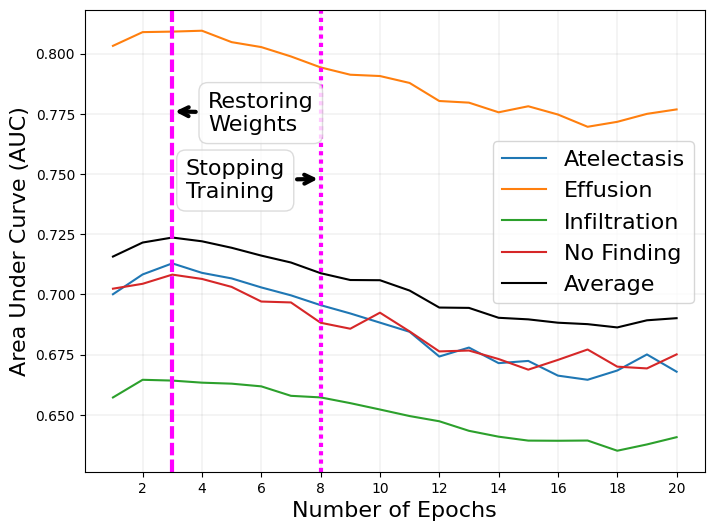

In [82]:
# with open('models/resnet_5/evaluations_first3.pkl', 'rb') as file:
#     evaluations = pickle.load(file)
with open('models/resnet_11/evaluations.pkl', 'rb') as file:
    evaluations = pickle.load(file)

plt.figure(figsize=(8, 6))

aucs_at_means = []
aucs_at_stds = []
aucs_ef_means = []
aucs_ef_stds = []
aucs_in_means = []
aucs_in_stds = []
aucs_nf_means = []
aucs_nf_stds = []
aucs_All_means = []
aucs_All_stds = []
baccs_means = []
baccs_stds = []
accs_means = []
accs_stds = []


for evals_per_epoch in evaluations.values():
    aucs_at = []
    aucs_ef = []
    aucs_in = []
    aucs_nf = []
    baccs = []
    accs = []
    
    for eval in evals_per_epoch:
        aucs_at.append(eval[0][0])
        aucs_ef.append(eval[0][1])
        aucs_in.append(eval[0][2])
        aucs_nf.append(eval[0][3])
        baccs.append(eval[1])
        accs.append(eval[2])

    aucs_at_means.append(np.mean(aucs_at))
    aucs_at_stds.append(np.std(aucs_at))
    aucs_ef_means.append(np.mean(aucs_ef))
    aucs_ef_stds.append(np.std(aucs_ef))
    aucs_in_means.append(np.mean(aucs_in))
    aucs_in_stds.append(np.std(aucs_in))
    aucs_nf_means.append(np.mean(aucs_nf))
    aucs_nf_stds.append(np.std(aucs_nf))
    aucs_All_means.append(np.mean(np.concatenate((aucs_at, aucs_ef, aucs_in, aucs_nf))))
    aucs_All_stds.append(np.std(np.concatenate((aucs_at, aucs_ef, aucs_in, aucs_nf))))
    baccs_means.append(np.mean(baccs))
    baccs_stds.append(np.std(baccs))
    accs_means.append(np.mean(accs))
    accs_stds.append(np.std(accs))
    
average_stds_per_epoch = []
for epoch_stds in zip(aucs_at_stds, aucs_ef_stds, aucs_in_stds, aucs_nf_stds):
    average_stds_per_epoch.append(np.mean(epoch_stds))

overall_average_std = np.mean(average_stds_per_epoch)
print(overall_average_std)


x_values = evaluations.keys()

font_size = 16

# plt.errorbar(x_values, aucs_at_means, yerr=aucs_at_stds, label='Atelectasis', fmt='-o', capsize=5)
# plt.errorbar(x_values, aucs_ef_means, yerr=aucs_ef_stds, label='Effusion', fmt='-o', capsize=5)
# plt.errorbar(x_values, aucs_in_means, yerr=aucs_in_stds, label='Infiltration', fmt='-o', capsize=5)
# plt.errorbar(x_values, aucs_nf_means, yerr=aucs_nf_stds, label='No Finding', fmt='-o', capsize=5)
# plt.errorbar(x_values, aucs_All_means, label='Average', fmt='-o', capsize=5)

plt.plot(x_values, aucs_at_means, label='Atelectasis')
plt.plot(x_values, aucs_ef_means, label='Effusion')
plt.plot(x_values, aucs_in_means, label='Infiltration')
plt.plot(x_values, aucs_nf_means, label='No Finding')
plt.plot(x_values, aucs_All_means, color='black', label='Average')

plt.ylabel("Area Under Curve (AUC)", fontsize=font_size)
plt.xlabel("Number of Epochs", fontsize=font_size)
plt.grid(color='grey', linestyle='-', linewidth=0.25, alpha=0.5)
plt.legend(fontsize=font_size, loc="best", bbox_to_anchor=(0.64, 0.54))
plt.xticks(range(2, max(x_values) + 1, 2))
plt.axvline(x=3, color='magenta', linestyle=(0, (3, 1)), linewidth=3)
plt.axvline(x=8, color='magenta', linestyle=(0, (1, 1)), linewidth=3)
# plt.text(2, 0.775, 'Stopping\nTraining', color='magenta', fontsize=font_size)
plt.annotate('Restoring\nWeights', xy=(3, 0.776), xytext=(4.2, 0.768), 
             arrowprops=dict(facecolor='magenta', arrowstyle='->', linewidth=3), fontsize=font_size,
            bbox=dict(facecolor='white', edgecolor='lightgray', boxstyle="round,pad=0.4", lw=1, alpha=0.8),  # Box properties
)

plt.annotate('Stopping\nTraining', xy=(8, 0.748), xytext=(3.45, 0.74), 
             arrowprops=dict(facecolor='magenta', arrowstyle='->', linewidth=3), fontsize=font_size,
            bbox=dict(facecolor='white', edgecolor='lightgray', boxstyle="round,pad=0.4", lw=1, alpha=0.8),  # Box properties
)



plt.savefig("evalsNewNew/epochs_reduceLR_10000samples_5runs_ANNOTATED.pdf", bbox_inches='tight', pad_inches=0)

plt.show()